In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import sys
basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')


## Build Composite library

In [22]:
from utils.library.composite_library import *
from utils.library.extra_functions import *
        
libraries = [
    ('m_ij', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
    ('v', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', None), #Not focused on flow dynamics
    ('c', 'Public/WT/ECad-GFP', 'scalar_library', None), #Not focused on cadherin dynamics, just include it as a source
]
    
extra_functions = [
    lambda data: symmetric_tensor_powers(data, 'm_ij'),
    lambda data: active_strain_decomposition_mesh(data, key='m_ij'),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'E_full', 'E_passive', 'E_active']),
    lambda data: add_static_sources_mesh(data, couple='m_ij'),
    lambda data: multiply_tensor_by_scalar(data, None, ['c']),
    lambda data: material_derivative_terms(data, key='m_ij'),
]


with h5py.File(os.path.join(libraries[0][1], 'derivative_library.h5'), 'r') as h5f:
    embryoIDs = list(h5f.keys())

with h5py.File('Public/mesh_dynamics_fitting.h5', 'w') as data:
    with tqdm(total=len(embryoIDs)) as pbar:
        pbar.set_description('Collecting embryo data')
        for embryoID in embryoIDs:
            pbar.set_postfix(embryoID=embryoID)
            group, feature_names = fill_group_info(data, embryoID, libraries, filename='mesh_derivative_library.h5')
            collect_library(group, 
                            libraries, 
                            feature_names, 
                            extra_functions=extra_functions)
            take_time_derivatives(group, libraries, window_length=5)
            library_to_tangent_space(group, libraries)
            pbar.update()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## Learn Myosin model

In [62]:
import pysindy as ps
from sklearn.decomposition import PCA
from utils.modeling.sindy_utils import *
from utils.modeling.fly_sindy import FlySINDy

tmin, tmax = -5, 15
n_components = 12

with h5py.File('Public/mesh_dynamics_fitting.h5', 'r') as h5f:
    X, X_dot, feature_names = collect_data(h5f, 'm_ij', tmin, tmax, collect_mesh_data, feature_names=overleaf_feature_names)
idx = feature_names.index('m_ij')
pca = PCA(n_components).fit(X[..., idx])

def transform(x, remove_mean=False):
    nfeats = x.shape[-1]
    x = x.transpose(0, 2, 1).reshape([-1, pca.n_features_])
    if remove_mean:
        x += pca.mean_
    x = pca.transform(x).reshape([-1, nfeats, pca.n_components_])
    x = x.transpose(0, 2, 1)
    return x

#X = transform(X)
#X_dot = transform(X_dot, remove_mean=True)

N = 12
constraint_lhs = np.zeros([N, len(feature_names)])
constraint_rhs = np.zeros(N)

#Advection on lhs
idx = feature_names.index('v dot grad m_ij')
constraint_lhs[0, idx] = 1
constraint_rhs[0] = -1
constraint_lhs[1, idx] = -1
constraint_lhs[1] = 1.05

#Co-rotation on lhs
idx = feature_names.index('[O, m_ij]')
constraint_lhs[2, idx] = 1
constraint_rhs[2] = -1
constraint_lhs[3, idx] = -1
constraint_rhs[3] = 1.05

#Detachment: (k_0 + k_1 c) m_ij
idx = feature_names.index('m_ij')
print(feature_names[idx:idx+2])
constraint_lhs[4, idx] =  1
constraint_rhs[4] = -0.02 #k_0 is negative (detachment)
constraint_lhs[5, idx  ] = 1
constraint_lhs[5, idx+1] = 1
constraint_rhs[5] = 0     #k_0 + k_1 < 0 (cadherin doesn't overrun)

#Static recruitment: (k_0 - k_1 c) Gamma Tr(m)
idx = feature_names.index('Static_DV Tr(m_ij)')
constraint_lhs[6, idx] = -1 #k_0 is positive (recruitment)
constraint_lhs[7, idx  ] = -1
constraint_lhs[7, idx+1] = -1

#Tension recruitment: (k_0 - k_1 c) Gamma Tr(m)
idx = feature_names.index('m_ij Tr(m_ij)')
constraint_lhs[8, idx] = -1 #k_0 is positive (recruitment)
constraint_lhs[9, idx  ] = -1
constraint_lhs[9, idx+1] = -1

#Strain recruitment: (k_0 - k_1 c) Gamma Tr(m)
idx = feature_names.index('m_ij Tr(E_full)')
constraint_lhs[10, idx] = -1 #k_0 is positive (recruitment)
constraint_lhs[11, idx  ] = -1
constraint_lhs[11, idx+1] = -1

optimizer = ps.ConstrainedSR3(constraint_lhs=constraint_lhs, constraint_rhs=constraint_rhs,
                              thresholder='l1',
                              threshold=1e-3, 
                              nu=1e-1, tol=1e-8, max_iter=5000, 
                              verbose=False, verbose_cvxpy=True, 
                              inequality_constraints=True)

print(X.shape, X_dot.shape)
from sklearn.model_selection import train_test_split
X = X.reshape([-1, X.shape[-1]])
X_dot = X_dot.reshape([-1, X_dot.shape[-1]])
X, _, X_dot, _ = train_test_split(X, X_dot, train_size=0.01)
print(X.shape, X_dot.shape)

sindy = FlySINDy(
    optimizer=optimizer,
    feature_names=feature_names,
    material_derivative=False,
    n_models=1)
sindy.fit(x=X, x_dot=X_dot)
sindy.print(lhs=['D_t m_ij'])

  0%|          | 0/7 [00:00<?, ?it/s]

['m_ij', 'c m_ij']
(120, 7188, 14) (120, 7188, 1)
(8625, 14) (8625, 1)
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 8653, constraints m = 8665
          nnz(P) + nnz(A) = 138076
settings: linear system solver = qdldl,
          eps_abs = 1.0e-08, eps_rel = 1.0e-08,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.1569e-04   1.00e+00   6.32e+02   1.00e-01   2.28e-02s
 200   4.5462e-02   1.35e-05   4

In [2]:
import pysindy as ps
from sklearn.decomposition import PCA
from utils.modeling.sindy_utils import *
from utils.modeling.fly_sindy import FlySINDy

tmin, tmax = -10, 10

with h5py.File('Public/mesh_dynamics_fitting.h5', 'r') as h5f:
    X, X_dot, feature_names = collect_data(h5f, 'm_ij', tmin, tmax, collect_mesh_data, 
                                           feature_names=overleaf_feature_names)
    
optimizer = ps.STLSQ(threshold=0., alpha=1e0, normalize_columns=True)

sindy = FlySINDy(
    optimizer=optimizer,
    feature_names=feature_names,
    material_derivative=True)
sindy.fit(x=X, x_dot=X_dot)
sindy.print(lhs=['D_t m_ij'])

  0%|          | 0/7 [00:00<?, ?it/s]

D_t m_ij = -0.024 m_ij + 0.041 c m_ij + 0.243 m_ij Tr(m_ij) + -0.208 c m_ij Tr(m_ij) + -1.111 m_ij Tr(E_full) + 1.232 c m_ij Tr(E_full) + 0.041 Static_DV Tr(m_ij) + -0.031 c Static_DV Tr(m_ij)


## Predict using learned model

  0%|          | 0/21 [00:00<?, ?it/s]

Initializing
Loaded mesh gradient operators
Using torchdiffeq solver
Done


  0%|          | 0/21 [00:00<?, ?it/s]

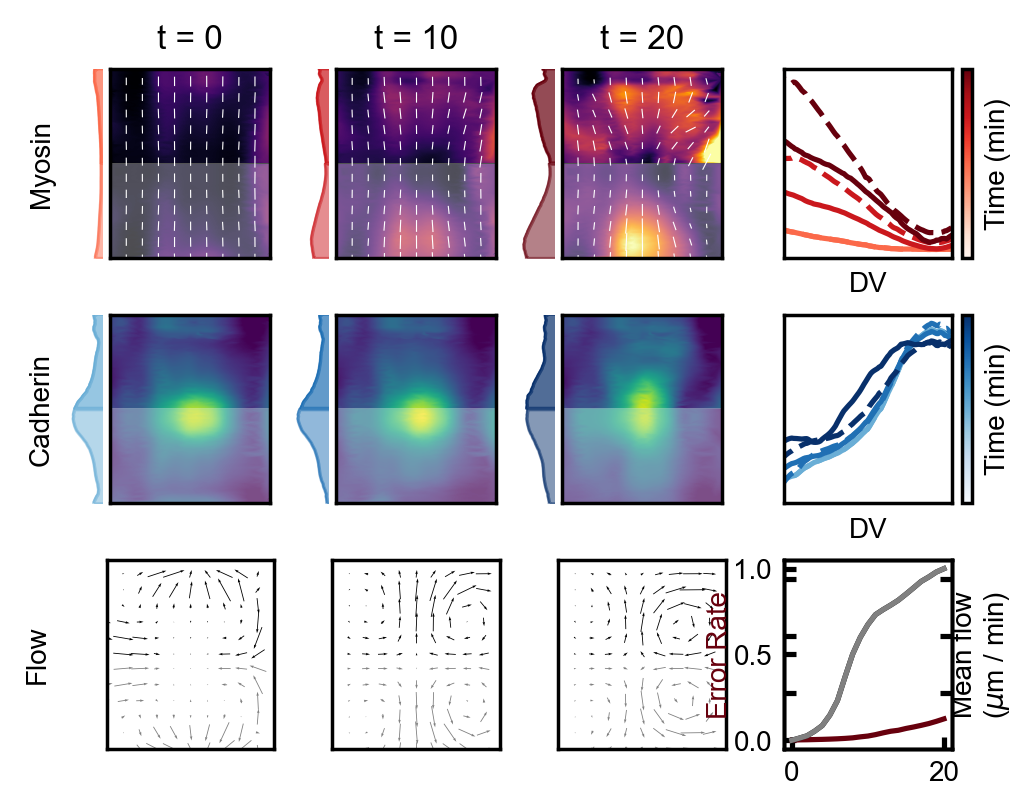

In [9]:
import torch
from scipy.interpolate import interp1d

from utils.geometry.closed_loop import ClosedLoopMesh
from utils.geometry.geometry_utils import MeshInterpolator, TangentSpaceTransformer
from utils.geometry.transforms import LeftRightSymmetrize
from utils.forecasting.plot_utils import *

class FittedModel(ClosedLoopMesh):
    def rhs(self, m, s, v, E, O):
        trE = self.einsum_('kkv->v', E)
        trm = self.einsum_('kkv->v', m)
        
        rhs = -(0.024 - 0.041 * s) * m
        rhs += (0.243 - 0.208 * s) * m * trm #* trm
        rhs += (1.111 - 1.232 * s) * m * trE
        rhs += (0.041 - 0.031 * s) * self.gamma_dv_ * trm

        #2D model
        rhs = -(0.066 - 0.061 * s) * m
        rhs += (0.489 + 0.318 * s) * m * self.einsum_('kkv->v', E)
        rhs += (0.564 - 0.393 * s) * m * trm
        rhs += (0.047 - 0.037 * s) * self.gamma_dv_ * trm
                
        return rhs

mesh_int = MeshInterpolator().fit(None)
tangent  = TangentSpaceTransformer().fit(None)
lrsym    = LeftRightSymmetrize().fit(None)

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/mesh_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = 0, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    
    M0 = data['fields/m_ij'][t_mask, ...][()]
    S0 = data['fields/c'][t_mask, ...][()]
    V0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
    
m0, s0, v0 = [], [], []
for i in tqdm(range(len(t0))):
    m0.append(tangent.inverse_transform(lrsym.transform(M0[i])))
    v0.append(tangent.inverse_transform(lrsym.transform(V0[i])))
    s0.append(lrsym.transform(S0[i]))

#Using a flow field interpolator in the loop instead of a neural network
vs0 = np.concatenate([
    np.stack(s0)[:, None],
    np.stack(v0),
], axis=1)
vs_int = interp1d(t0, vs0, axis=0, fill_value='extrapolate')
v_model = lambda t, y: vs_int(t)
#v_int = interp1d(t0, v0, axis=0, fill_value='extrapolate')
#v_model = lambda t, y: v_int(t)

y0 = np.concatenate([
    m0[0].reshape([4, 1797]),
    s0[0].reshape([1, 1797])
])
device = torch.device('cuda:0')
y0 = torch.from_numpy(y0).to(device)
t = torch.DoubleTensor(t0).to(device)
v_model = lambda t, y: torch.from_numpy(vs_int(t.cpu().numpy())).to(y.device)


model = FittedModel(v_model=v_model, sigma=.5)
model.to(device)
m, s, v = model.integrate(y0, t)
v = v[:, 1:]
print('Done')    

M, S, V = [], [], []
M0, S0, V0 = [], [], []
for i in tqdm(range(len(t0))):
    M.append(mesh_int.inverse_transform(m[i]))
    S.append(mesh_int.inverse_transform(s[i]))
    V.append(mesh_int.inverse_transform(v[i]))
    M0.append(mesh_int.inverse_transform(m0[i]))
    S0.append(mesh_int.inverse_transform(s0[i]))
    V0.append(mesh_int.inverse_transform(v0[i]))

comparison_plot(t0,
                ('Myosin', np.stack(M), np.stack(M0)),
                ('Cadherin', np.stack(S), np.stack(S0)),
                ('Flow', np.stack(V), np.stack(V0)),
                dt=10)

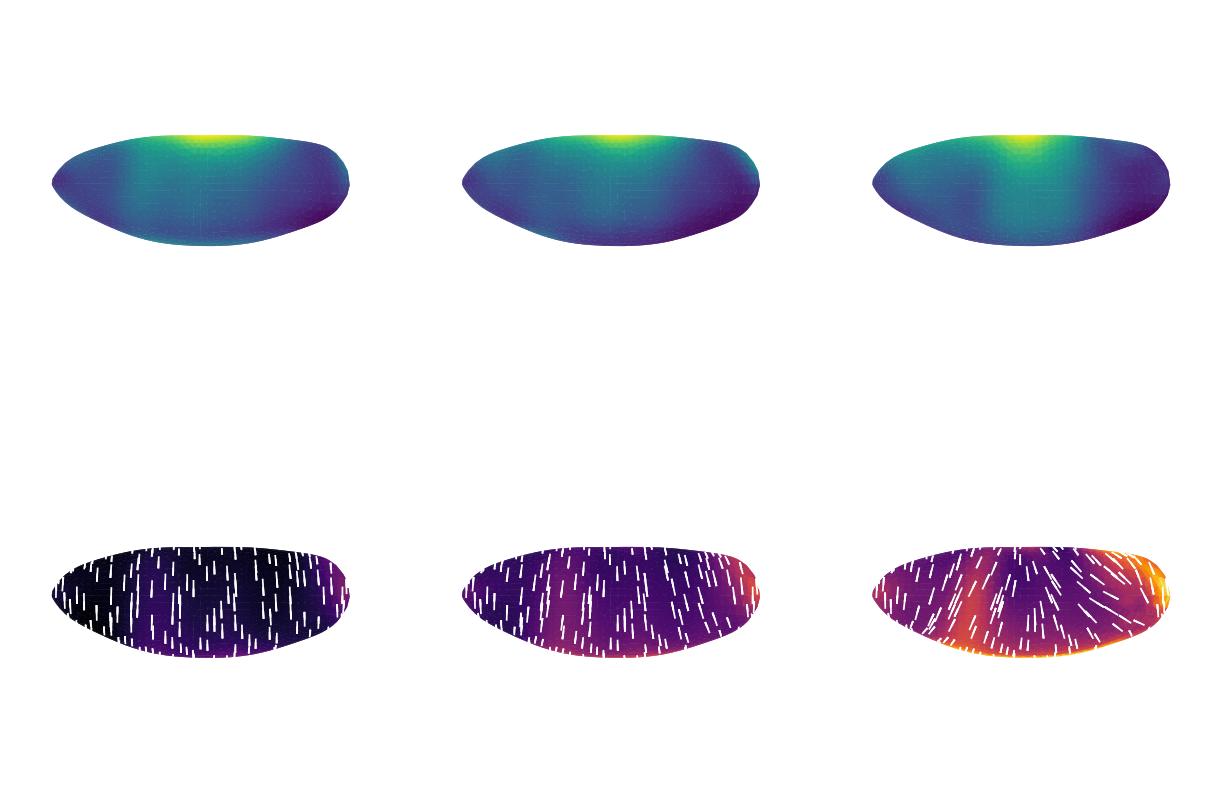

In [38]:
from utils.geometry.plot_utils import *
from utils.geometry.geometry_utils import TangentSpaceTransformer
from sklearn.pipeline import Pipeline
fig, ax = plt.subplots(2, 3, dpi=250, subplot_kw=dict(projection='3d'))

mnorm = np.linalg.norm(m0, axis=(1, 2))
vmin, vmax = np.min(mnorm), np.max(mnorm)
pipe = Pipeline([
    ('mesh', MeshInterpolator()),
    ('tangent', TangentSpaceTransformer()),
]).fit(mnorm)
    

for i in range(3):
    #plot_tensor3D(ax[0, i], pipe.transform(m0[i*10]), vmin=vmin, vmax=vmax)
    color_3D(ax[0, i], pipe.transform(S0[i*10]))
    plot_tensor3D(ax[1, i], pipe.transform(M[i*10].reshape([2, 2, 236, 200])), vmin=vmin, vmax=vmax)

In [21]:
from utils.geometry.geometry_utils import embryo_mesh

verts = embryo_mesh.coordinates()
pix_scale = 0.2619
verts = verts * pix_scale

ptp = np.ptp(verts, axis=0)
radius = np.mean(ptp[:2]/2)

print(f'3D Embryo: radius={radius:.3g}, circumference={2*np.pi*radius:.3g}, length={ptp[2]:.3g} (all in microns)')
print(f'2D Embryo: circumference={dv_max-dv_min:.3g}, length={ap_max-ap_min:.3g} (all in microns)')

3D Embryo: radius=86.7, circumference=545, length=455 (all in microns)
2D Embryo: circumference=534, length=452 (all in microns)
